## Seeding and Device

In [6]:
import os
import random

import numpy as np
import torch

In [7]:
def seed_all(seed: int = 1930):
    """Seed all random number generators."""
    print("Using Seed Number {}".format(seed))

    os.environ["PYTHONHASHSEED"] = str(
        seed
    )  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    random.seed(
        seed
    )  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False


def seed_worker(_worker_id):
    """Seed a worker with the given ID."""
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


_ = seed_all(1992)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using Seed Number 1992


## Introduction

> Extracted from Kaggle 

Serious complications can occur as a result of malpositioned lines and tubes in patients. Doctors and nurses frequently use checklists for placement of lifesaving equipment to ensure they follow protocol in managing patients. Yet, these steps can be time consuming and are still prone to human error, especially in stressful situations when hospitals are at capacity.

Hospital patients can have catheters and lines inserted during the course of their admission and serious complications can arise if they are positioned incorrectly. Nasogastric tube malpositioning into the airways has been reported in up to 3% of cases, with up to 40% of these cases demonstrating complications [1-3]. Airway tube malposition in adult patients intubated outside the operating room is seen in up to 25% of cases [4,5]. The likelihood of complication is directly related to both the experience level and specialty of the proceduralist. Early recognition of malpositioned tubes is the key to preventing risky complications (even death), even more so now that millions of COVID-19 patients are in need of these tubes and lines.

The gold standard for the confirmation of line and tube positions are chest radiographs. However, a physician or radiologist must manually check these chest x-rays to verify that the lines and tubes are in the optimal position. Not only does this leave room for human error, but delays are also common as radiologists can be busy reporting other scans. Deep learning algorithms may be able to automatically detect malpositioned catheters and lines. Once alerted, clinicians can reposition or remove them to avoid life-threatening complications.

The Royal Australian and New Zealand College of Radiologists (RANZCR) is a not-for-profit professional organisation for clinical radiologists and radiation oncologists in Australia, New Zealand, and Singapore. The group is one of many medical organisations around the world (including the NHS) that recognizes malpositioned tubes and lines as preventable. RANZCR is helping design safety systems where such errors will be caught.

In this competition, you’ll detect the presence and position of catheters and lines on chest x-rays. Use machine learning to train and test your model on 40,000 images to categorize a tube that is poorly placed.

The dataset has been labelled with a set of definitions to ensure consistency with labelling. The normal category includes lines that were appropriately positioned and did not require repositioning. The borderline category includes lines that would ideally require some repositioning but would in most cases still function adequately in their current position. The abnormal category included lines that required immediate repositioning.

If successful, your efforts may help clinicians save lives. Earlier detection of malpositioned catheters and lines is even more important as COVID-19 cases continue to surge. Many hospitals are at capacity and more patients are in need of these tubes and lines. Quick feedback on catheter and line placement could help clinicians better treat these patients. Beyond COVID-19, detection of line and tube position will ALWAYS be a requirement in many ill hospital patients.

## Dataset: Understanding our Data

We will go through the data that we were given.

### Data Catalog/Description

In this competition, you'll detect the presence and position of catheters and lines on chest x-rays. Use machine learning to train and test your model on $40,000$ images to categorize a tube that is poorly placed.

- Train Set: $30083$ images
- Public Test Set: $3582$ images
- Private Test Set: ~$14000$ images
- `train.csv`: containing **image IDs, labels and patient IDs**.
- `sample_submission.csv`: a sample submission file in the correct format
- `test/`: test images
- `train/`: training images

In particular the train csv has these columns:

- StudyInstanceUID - unique ID for each image
- ETT - Abnormal - endotracheal tube placement abnormal
- ETT - Borderline - endotracheal tube placement borderline abnormal
- ETT - Normal - endotracheal tube placement normal
- NGT - Abnormal - nasogastric tube placement abnormal
- NGT - Borderline - nasogastric tube placement borderline abnormal
- NGT - Incompletely Imaged - nasogastric tube placement inconclusive due to imaging
- NGT - Normal - nasogastric tube placement borderline normal
- CVC - Abnormal - central venous catheter placement abnormal
- CVC - Borderline - central venous catheter placement borderline abnormal
- CVC - Normal - central venous catheter placement normal
- Swan Ganz Catheter Present
- PatientID - unique ID for each patient in the dataset

## Objective: Multi-Label Binary Classification

In general, a patient's single chest X-ray could present multiple medical conditions.


<img src="https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/RANZCR%20CLiP%20-%20Catheter%20and%20Line%20Position%20Challenge/images/patient_id_323464123.PNG" style="margin-left:auto; margin-right:auto"/>
<p style="text-align: center">
    <b>Fig 1: Patient ID 323464123; By Hongnan G.</b>
</p>

- Patient 323464123's first row corresponds to an unique image defined by the study instance UID.
- Noticed the 1's under the columns `ETT-Normal`, `NGT - Incompletely Images`, `CVC-Borderline` and `CVC-Normal` and 0's elsewhere.
- Unlike multi-class classification, where **classes are mutually exclusive**, **multi-label** is not.
- For example, a patient's X-ray scan of the lungs can show up **pneumonia and covid-19** (both are conditions), as a result the *class labels* are not mutually exclusive (unlike multi-class). The same logic is applied in this setting, where the tube can be labelled differently.

## Metrics: Establish Metrics

### Macro-Averaged AUROC

Then Macro-Average AUROC is calculated for each individual class, and then averaged over the total number of classes.

$$\text{Macro-Average AUROC} = \frac{1}{\text{num_class}}\sum_{i=1}^{\text{num_class}}R_{i}$$

where $R_i$ is the AUROC score for each individual class.

A small example clears up the air:

- Consider 3 classes of apple, banana and carrot as a multi-label problem with class index $[0, 1, 2]$.
- `y_true`: is a one-hot encoded matrix of 4 rows and 3 columns. The rows means 4 samples, and columns mean the class where 1 means positive and 0 negative. 
            It is not a surprise that each row can hold multiple 1's since it is a multi-label problem. `[0, 1, 1]` just means that the "image data" contains both banana and carrot;
- `y_pred`: the predicted matrix, and is the same shape as `y_true`.

We now treat the problem running multiple binary ROC computation:

- Calculate the ROC score between column $i$ of `y_true` and `y_pred` respectively and call them $R_i$;
- Sum $R_i$ and divide by the number of classes and get the Macro-Averaged AUROC.


In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score

y_true = np.asarray([[0, 1, 1],
                     [0, 0, 1],
                     [1, 1, 0],
                     [1, 1, 1]])

y_pred = np.asarray([[0, 1, 0],
                     [1, 0, 0],
                     [1, 1, 0],
                     [1, 0, 1]])

macro_auroc = np.mean([roc_auc_score(y_true[:, i], y_pred[:, i]) for i in range(3)])
macro_auroc

0.75

!!! tip
    For a more wholesome treatment of metrics, see my Melanoma write-up and [blog](https://reighns92.github.io/reighns-ml-blog/reighns_ml_journey/machine_learning_and_deep_learning/metrics/classification_metrics/roc_pr_curve/).

## Validation and Resampling: Cross-Validation

### How should we split out data into folds?

We should examine the data for a few factors:

1. Is the data $\mathcal{X}$ imbalanced?
2. Is the data $\mathcal{X}$ generated in a **i.i.d.** manner, more specifically, if I split $\mathcal{X}$ to $\mathcal{X}_{train}$ and $\mathcal{X}_{val}$, can we ensure that $\mathcal{X}_{val}$ has no dependency on $\mathcal{X}_{train}$?

We came to the conclusion:

1. Yes, there is quite some imbalanced distribution, in particular, **CVC - Normal**, **ETT - Normal** and **CVC - Borderline** are significantly more than the rest of the classes. Therefore, a stratified cross validation is reasonable. Stratified KFold ensures that relative class frequencies is approximately preserved in each train and validation fold. More concretely, we will not experience the scenario where $X_{train}$ has $m^{+}$ and $m^{-}$ positive and negative samples, but $X_{val}$ has only $p^{+}$ positive samples only and 0 negative samples, simply due to the scarcity of negative samples

2. In medical imaging, it is a well known fact that most of the data contains patient level repeatedly. To put it bluntly, if I have 100 samples, and according to **PatientID**, we see that the id 123456 (John Doe) appeared 20 times, this is normal as a patient can undergo multiple settings of say, X-rays. If we allow John Doe's data to appear in both train and validation set, then this poses a problem of information leakage, in which the data is no longer **i.i.d.**. One can think of each patient has an "unique, underlying features" which are highly correlated across their different samples. As a result, it is paramount to ensure that amongst this 3255 unique patients, we need to ensure that each unique patients' images **DO NOT** appear in the validation fold. That is to say, if patient John Doe has 100 X-ray images, but during our 5-fold splits, he has 70 images in Fold 1-4, while 30 images are in Fold 5, then if we were to train on Fold 1-4 and validate on Fold 5, there may be potential leakage and the model will predict with confidence for John Doe's images. This is under the assumption that John Doe's data does not fulfill the i.i.d process.

### StratifiedGroupKFold

With the above consideration, we will use `StratifiedGroupKFold` where $K = 5$ splits. There wasn't this splitting function in scikit-learn at the time of competition and as a result, we used a custom written (by someone else) `RepeatedStratifiedGroupKFold` function and just set `n_splits = 1` to get **StratifiedGroupKFold** (yes we cannot afford to do repeated sample, so setting the split to be 1 will collapse the repeated function to just the normal stratified group kfold). However, as of 2022, this function is readily available in the **Scikit-Learn** library.

To recap, we applied stratified logic such that each train and validation set has an **equal** weightage of positive and negative samples. We also grouped the patients in the process such that patient $i$ will not appear in both training and validation set.

> Data leakage can cause you to have blind confidence on your model. We are also guilty of committing one since we trained our models with the NiH pretrained weights, without taking into consideration if the weights overlap with the training and validation folds information. In other words, we did not check properly if the weights trained on the NiH dataset has information in our RANZCR dataset. Take note this is different from training altogether on the NiH dataset, we are merely using the weights instead of the imagenet weights, which brings to the next point.

Referring to figure 1, patient 323464123 has 6 images uniquely recorded on different visits. We should absolutely put them all in either train or validation set, as if say 2 images are in train and 4 in validation, there might be data leakage.



### Cross-Validation Workflow

To recap, we have the following:

- **Training Set ($X_{\text{train}}$)**: This will be further split into K validation sets during our cross-validation. This set is used to fit a particular hypothesis $h \in \mathcal{H}$.
- **Validation Set ($X_{\text{val}}$)**: This is split from our $X_{\text{train}}$ during cross-validation. This set is used for model selection (i.e. find best hyperparameters, attempt to produce a best hypothesis $g \in \mathcal{H}$).
- **Test Set ($X_{\text{test}}$)**: This is an unseen test set, and we will only use it after we finish tuning our model/hypothesis. Suppose we have a final best model $g$, we will use $g$ to predict on the test set to get an estimate of the generalization error (also called out-of-sample error).

<figure>
<img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/aiap-coronary-artery-disease/data/images/cv.PNG' width="500"/>
<figcaption align = "center"><b>Pipeline.</b></figcaption>
</figure>

---

<figure>
<img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/images/grid_search_workflow.png' width="500"/>
<figcaption align = "center"><b>Courtesy of scikit-learn on a typical Cross-Validation workflow.</b></figcaption>
</figure>

## Transfer Learning: The core of Deep Learning

As we all know, if we train on `imagenet` weights, we may take quite a while to converge, even if we finetune it. The intuition is simple, `imagenet` were trained on many common items in life, and none of them resemble closely to the **image structures of X-rays**. Therefore, we have a few options.

- Freeze earlier layers but unfreeze the later Conv Layers: this is intuitive as earlier layers detect shapes and colors, all low level details that is very useful even for such **dissimilar tasks**, and unfreeze the later conv layers which is what we call the "abstract feature layers", where it is more important for the model to learn from scratch. 
- Fine-Tuning;
- Feature Extraction;

### Fine-Tuning

Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. This is what we will be doing and we managed to find a set of `pretrained` weights trained specifically on this dataset as a starting point. The weights can be found **[here](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/discussion/215910)**.

We used a few models and found out that `resnet200d` has the best results on this set of training images. The reason we used this is mostly empirical, but using `gradcam` we can see how the model sees the images. 

### Feature Extraction

ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained. This is less relevant to us as we aren't using it for feature extractions.

Therefore, the model may have a hard time detecting abstract features such shapes and details from the X-rays. We can of course unfreeze all the layers and retrain them from scratch, using various backbones, 

## Preprocessing

Most preprocessing techniques we do in an image recognition competition is mostly as follows:





### Mean and Standard Deviation

- Perform **mean and std** for the dataset given to us. Note that this step may make sense on paper, but empirically, using imagenet's default mean std will always work as well, if not better. Nevertheless, here are the stats:
    - Imagenet:
        - `mean = [0.485, 0.456, 0.406]` and;
        - `std = [0.229, 0.224, 0.225]`
        
    - RANZCR:
        - `mean = [0.4887381077884414, ...]` and;
        - `std = [0.23064819430546407, ...]`

### Channel Distribution

This is usually done to check for "surprises". More specifically, I remember vividly when participating in Singapore Airline challenge where the classifier recognize weird objects as luggages. After plotting the pixel histogram, we observed that the luggages colors are all of a non-normal distribution, in fact, it is quite scattered. Then it dawned upon us that the classifier is learning the "color" too much, instead of the shape of the luggage. When we grayed out the images, the classifier starts to ignore the noise in the colors, and instead focus on other features like shapes. So this removes signal to noise in a way - using the objection detection example such as detecting a strawberry in a tree full of green leaves, then color is important, but if we detect leaves in a tree full of green leaves, we do not wish to incorporate color here as anything green might suggest that it is a leaf.

We found, and as mentioned also by [Rueben Schmidt](https://www.kaggle.com/reubenschmidt) in [this post](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/discussion/224146), there are some images that have black borders around them. I experimented by removed them during both the training process. There was no significant increase on the LB score, even if there was, it is in the 3-4th decimal places, but I noticed my local cv increased, so I think that some noise are removed locally, but not reflected in the test set. Therefore, during inference, I also removed the black borders, which should be the correct approach (learning from mistakes!). In conclusion, there is a small boost in score, if I keep this consistent in both training and inference, I reckon that no surprise factor would pop out.

Here is the code:

```python
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask  = image > 0
image = image[np.ix_(mask.any(1), mask.any(0))]
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
```

Notice that the code removes any pixel that is > 0, where black pixel is 0.

> On hindsight for the Singapore Airline project, I now know there is **GradCam**, where we can see how the model is learning, as it will highlight the areas on which the model is focusing on in an image. 

### Convert Gray to RGB

We know that **X-rays** are **Grayscale** images so converting a grayscale image to RGB is just setting `R=G=B=Grayscale` pixel for all channels.

In [11]:
import cv2

image = cv2.imread("../images/1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617.png", cv2.IMREAD_GRAYSCALE)
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

(256, 256)
(256, 256, 3)


## Augmentations

We know that augmentation is central in an image competition, as essentially we are adding more data into the training process, effectively **reducing overfitting and improve generalization**.

Heavy augmentations are used during Train-Time-Augmentation. But during Test-Time-Augmentation, we used the same set of training augmentations to inference with $100\%$ probability.

### Train-Time Augmentation

The typicals!

```python
train_augmentations = [
    albumentations.RandomResizedCrop(
        height=config.image_size, width=config.image_size
    ),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ShiftScaleRotate(p=0.5),
    albumentations.HueSaturationValue(
        hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5
    ),
    albumentations.RandomBrightnessContrast(
        brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5
    ),
    albumentations.CoarseDropout(p=0.5),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
        p=1.0,
    ),
    ToTensorV2(p=1.0),
]
```


### Test-Time Augmentation

The exact same set of augmentations were used in inference. Not all TTAs provided a increase in score.

## Model Architectures, Training Parameters & Tricks

### Model Architecture

#### Overview

A brief overview of our model architecture is shown in fig 2.1 and 2.2:


<div class="container" style="display: inline-block;">  
  <figure>
  <div style="float: left; padding: 10px;">
    <img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/RANZCR%20CLiP%20-%20Catheter%20and%20Line%20Position%20Challenge/images/single_head.png' width="666" height="666" align="center"/>
    <figcaption align="center"><b>Fig 2.1; Single-Head Approach<br> courtesy of Tawara</b></figcaption>
  </div>

  <div style="float: right; padding: 10px;">
    <img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/RANZCR%20CLiP%20-%20Catheter%20and%20Line%20Position%20Challenge/images/multi_heads.png' width="666" height="666" align="center"/>
    <figcaption align="center"><b>Fig 2.2; Multi-Head Approach<br> courtesy of Tawara</b></figcaption>
  </div>
  </figure>
</div>

#### Backbone

We used both `resnet200d` and `seresnet152d` but will focus more on the first model.

We used `resnet200d`, a ResNet variant model as our main backbone. 

`ResNet-D` is a modification on the ResNet architecture that utilises an average pooling tweak for downsampling. The motivation is that in the unmodified ResNet, the 1×1 convolution for the downsampling block ignores 3/4 of input feature maps, so this is modified so no information will be ignored.

!!! info
    So 1x1 convolutional reduces the feature maps depth but not the width or height while pooling reduces the width or height but not the depth. I think the results are better with the latter.
    
In our case, we did the following:

- Create the model with: `model = timm.create_model('resnet200d', pretrained=True, num_classes=1000)`;
- Load the pretrained weights from [NiH trained](https://www.kaggle.com/ammarali32/startingpointschestx);
- Reset Classifier Head with Global Average Pooling: `self.model.reset_classifier(num_classes=0, global_pool="avg")`;
- Attach our own Classifier Head with 11 classes.

In [12]:
import torch
import timm
from torchinfo import summary

model = timm.create_model('resnet18', pretrained=True, num_classes=1000)
batch_size = 2
image_shape = (3, 224, 224)
input_image_tensor = torch.rand(size=(batch_size, *image_shape))


# print(summary(model, (2, 3, 224, 224)))

- `model.reset_classifier(num_classes=0, global_pool="")` means we **do not want global average pooling** and thus the shape at the last conv layer (penultimate layer) is $(2, 512, 7, 7)$
- `model.reset_classifier(num_classes=0, global_pool="avg")` means we **do want global average pooling** and thus the shape at the last conv layer (penultimate layer) is $(2, 512)$
   whereby for each and every of the 512 feature maps $f_i$, we average $f_i$ across all pixels (i.e. if $f_i$ is 3 by 3 then average means add all $3 \times 3 = 9$ pixels and average) and concat to become one $512$ vector. 

In [13]:
model = timm.create_model('resnet18', pretrained=True, num_classes=1000)

o = model(input_image_tensor)
print(f'Original shape: {o.shape}')

model.reset_classifier(num_classes=0, global_pool="")

o = model(input_image_tensor)
print(f'Unpooled shape: {o.shape}')

Original shape: torch.Size([2, 1000])
Unpooled shape: torch.Size([2, 512, 7, 7])


In [14]:
model = timm.create_model('resnet18', pretrained=True, num_classes=1000)

o = model(input_image_tensor)
print(f'Original shape: {o.shape}')

model.reset_classifier(num_classes=0, global_pool="avg")

o = model(input_image_tensor)
print(f'Pooled shape: {o.shape}')

Original shape: torch.Size([2, 1000])
Pooled shape: torch.Size([2, 512])


**Note:**

Empirically, we realized the `ResNet200D` works very well for this particular task. We all asked ourselves why, and it was also discussed by many, but we all agreed that through various experiments, this model seems to consistently outperform their other SOTA counterparts. However, the closest possible paper on [Revisiting ResNets: Improved Training and Scaling Strategies](https://arxiv.org/abs/2103.07579).

Of course, to add diversity to our final predictions, we trained one more `SeResNet152d` as well. In general, ensembling models with vastly different architectures may result in a more robust solution. As an example, you can think of each model as a "average learner", and if their structure is different, it may very well so learn information that the other model might miss, hence ensembling them will average out such differences. Later on I will touch upon an ensembling technique called **Forward Ensembling/Selection** in this task, it has since worked well for other similar competitions.

#### Classifier Heads - Multi-Head Approach

We will focus a bit more on the multi-heads we used.

- [Reading on self attention in X-ray](https://towardsdatascience.com/self-attention-in-computer-vision-2782727021f6)

- [What is a multi-headed model? And what exactly is a 'head' in a model?](https://stackoverflow.com/questions/56004483/what-is-a-multi-headed-model-and-what-exactly-is-a-head-in-a-model/56004582)

##### Intuition

The usage of multi-heads is not uncommon, let us detail a simple example in Object Detection.

The image below shows the general architecture:

![alt](../images/object_detection_head.png) 

- In object detection, we want to predict two things, the **image class label** and its **bounding box coordinates**;
- The backbone network ("convolution and pooling") is responsible for extracting a feature map from the image that contains higher level summarized information. Each head uses this feature map as input to predict its desired outcome. 
- The main intuition why feature maps of the last few layers (last layer usually) are important is one needs to recognize the earlier conv layer's feature maps find simple features like shapes, sizes, edges from an image, while the deep conv layers will be of more abstract features in an image. As a result, we really just want the abstract feature maps as they are **more class specific to the image** instead of the earlier layers which gives **generic shapes**.
- Let us say you used a **ResNet** as the backbone, then:
    - Remove the classifier head, or rather just take the backbone which is all layers up to the last conv layer: say at the last layer. the output feature maps has a shape of (512, 7, 7);
    - These 512 feature maps of 7 by 7 are high level information of the image encoded;
    - We then connect a classification head to the backbone to predict the image's class given the true class labels;
    - We then connect a regression head to the backbone to predict the image's bounding box coordinates given the true bounding box coordinates;
- We can create two heads, one responsible for **classification** for the class label and the other **regression** to work on the localization of the bounding boxes;
- Thus here we have 2 heads, one for classifying what class the image object is, the other is to localize where the image object is.
- The loss that you optimize for during training is usually a weighted sum of the individual losses for each prediction head. 

##### Multi-Head for Multi-Label

Since we have 11 targets in this competition and they can be divided into 4 distinct groups: 

- `ETT`,
- `NGT`,
- `CVC` and
- `Swan`. 

We envision that different groups have different areas in images to focus on. One possible way to leverage this idea is a **multi-head approach** we talked about. Multipe groups can share one single CNN backbone but have independent **classifier** heads.

<div class="container" style="display: inline-block;">  
  <figure>
  <div style="float: left; padding: 10px;">
    <img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/RANZCR%20CLiP%20-%20Catheter%20and%20Line%20Position%20Challenge/images/single_head.png' width="666" height="666" align="center"/>
    <figcaption align="center"><b>Fig 2.1; Single-Head Approach<br> courtesy of Tawara</b></figcaption>
  </div>

  <div style="float: right; padding: 10px;">
    <img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/projects/RANZCR%20CLiP%20-%20Catheter%20and%20Line%20Position%20Challenge/images/multi_heads.png' width="666" height="666" align="center"/>
    <figcaption align="center"><b>Fig 2.2; Multi-Head Approach<br> courtesy of Tawara</b></figcaption>
  </div>
  </figure>
</div>
 With this in mind, let us move on:

**Multi-Label**

This is a multi-label classification problem. The section on the activation functions fully explained the single head version of using sigmoid layer. In fact, it is not uncommon to train N number of heads on a N-class Multi-Label problem. One thing to note is that if your classification head is `Linear` layer only (with BCE loss), then the back gradient propagation is the same whether you train one head, or multiple heads. However, we have non-linear layers in the head, including the `SpatialAttentionBlock`! At the time of writing, I won't say I fully grasp of all the inner workings of an Attention Module across various use cases, but an analogy to aid my understanding is as follows:

> Having taken Learning From Data from Professor Yaser, the inner joke is about the Hypothesis Space. Let me elaborate, given a resnet200D as our hypothesis space $\mathcal{H}$, we aim to find a $h \in \mathcal{H}$ that best represents our true function $f$. Now suppose our learning algorithm $\mathcal{A}$ does a good job in helping us to find such a optimal $h$, it may take time, maybe say 100 epochs before finding it. Now if I break down the problem into 4 parts, each corresponding to a group, and we "aid" the learning algorithm by giving more attention to 4 focused areas, then we might find both a good $h$ that estimate the $f$ well, and may even be faster!

> If the above is too meh for understanding, imagine you are taking an exam in Machine Learning, as we all know, this field is a rabbit hole with never ending topics, let us say that there are 20 topics for you to study for the exam, you are dilligent and does that. But you have limited time and you decided to devote equal time to each topic, the consequence is you may not perform well for the exam due to limited understanding of each topic. Now, if I were to tell you that, hey, out of the 20 topics, can you study these 4 topics, as I think they have a higher chance of coming out, you will likely do better in the exam given that you devoted much more time on those "focused (attention!)" topics.


The following code explains this methodology with reference to the above images.

We first note to the readers that typically, if we use a single head approach, where if we were given a problem set $\mathcal{D} = X \times y$, a hypothesis space $\mathcal{H}$ we learn from a learning algorithm $\mathcal{A}$, producing a final hypothesis $g$ (or h, depends on your notation), that predicts as such $g(X_{val}) = y_{\text{val_pred}}$, where each element in $y_{\text{val_pred}}$ corresponds to the class. Think of the basic MNIST example, our prediction vector's first element corresponds to the probability of it being an 0, and so on and so forth (assuming we use soft labels here). 

The change here is after the feature extraction layer (i.e. the feature logits after backbone), instead of just connecting it to a linear head for classification, we instead split the 11 outputs to 4 distinct groups. Each group will go through the head independent of the others, and this may prompt the model to put more **attention** on the independent groups. Finally, we `torch.cat(..,axis=1)` the outputs after they gone through their respective heads to recover the 11 outputs.

```python
model = CustomModel(
    config,
    pretrained=True,
    load_weight=True,
    load_url=False,
    out_dim_heads=[3, 4, 3, 1],
)
# Multi Head
for i, out_dim in enumerate(self.out_dim_heads):
    layer_name = f"head_{i}"
    layer = torch.nn.Sequential(
        SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
        torch.nn.AdaptiveAvgPool2d(output_size=1),
        torch.nn.Flatten(start_dim=1),
        torch.nn.Linear(in_features, in_features),
        self.activation,
        torch.nn.Dropout(0.3),
        torch.nn.Linear(in_features, out_dim),
    )
    setattr(self, layer_name, layer)

def forward(self, input_neurons):
    """Define the computation performed at every call."""
    if self.use_custom_layers is False:
        output_predictions = self.model(input_neurons)
    else:
        if len(self.out_dim_heads) > 1:
            output_logits_backbone = self.architecture["backbone"](input_neurons)
            multi_outputs = [
                getattr(self, f"head_{i}")(output_logits_backbone)
                for i in range(self.num_heads)
            ]
            output_predictions = torch.cat(multi_outputs, axis=1)
```

> We built-upon fellow Kaggler **Tawara’s** Multi-head model for our best scoring models. In particular, we experimented with the activation functions and dropout rates. We found models with `Swish` activation in the `multi-head` component of the network to perform > best in our experiments. Our best scoring single model is a multi-head model with a `resnet200d` backbone. In particular, one single fold of `resnet200d` gives a private score of 0.970. 
> Another very interesting approach is 3-4 stage training. We did not have time to experiment with the 3-4 stage training as we joined the competition late.

**Model Architectures:**
                    layer = torch.nn.Sequential(
                        SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
                        torch.nn.AdaptiveAvgPool2d(output_size=1),
                        torch.nn.Flatten(start_dim=1),
                        torch.nn.Linear(in_features, in_features),
                        self.activation,
                        torch.nn.Dropout(0.3),
                        torch.nn.Linear(in_features, out_dim),
                    )
- **Backbone**: `ResNet200D` and `SeResNet152d`
- **Classifier Head:** Separated and Independent **Spatial-Attention Module** and the typical Multi-Layer Perceptron for Target Group (ETT(3), NGT(4), CVC(3), and Swan(1)).
    - **Spatial-Attention Module:** `SpatialAttentionBlock(in_features, [64, 32, 16, 1])`
    - **MLP:**: `Linear -> Swish -> Dropout -> Linear`; It is worth noting after the `Linear` layer, there is a `Sigmoid` layer in this particular setup as we are using `BCEWITHLOGITSLOSS` from PyTorch for numerical stability.
- **Activation:** One thing to note is we used `Swish` in our Classifier Head. Swish is a smooth and non-monotonic function, the latter contrasts when compared to many other activations. I will explain a bit in the next section.
    


### Activation Functions

As we all know, activation functions are used to transform a neurons' linearity to non-linearity and decide whether to "fire" a neuron or not.

We chose **Swish** as our main activation function in the classifier head layers.

#### Swish

When we design or choose an activation function, we need to ensure the follows:

- (Smoothness) Differentiable and Continuous: For example, the sigmoid function is continuous and hence differentiable. If the property is not fulfilled, we might face issues as backpropagation may not be performed properly since we cannot differentiate it.If you notice, the heaviside function is not. We cant perform GD using the HF as we cannot compute gradients but for the logistic function we can. The gradient of sigmoid function g is g(1-g) conveniently

- Monotonic: This helps the model to converge faster. But spoiler alert, Swish is not monotonic.

The properties of Swish are as follows:

- Bounded below: It is claimed in the paper it serves as a strong regularization.
- Smoothness: More smooth than ReLU which allows the model to optimize better, the error landscape, when smoothed, is easier to traverse in order to find a minima. An intuitive idea is the hill again, imagine you traverse down Bukit Timah Hill, vs traversing down Mount Himalaya LOL!!!

Let us see how swish looks like when plotted.

In [15]:
import math

import matplotlib.pyplot as plt
import numpy as np

def swish(x):
    sigmoid = 1 / (1 + np.exp(-x))
    swish = x * sigmoid
    return swish


epsilon = 1e-20
x = np.linspace(-10, 10, 10)
z = swish(x)
print(f"x={x}")
print(f"\nz=swish(x)={z}")
print(f"\nmin z = {min(z)}")

x=[-10.          -7.77777778  -5.55555556  -3.33333333  -1.11111111
   1.11111111   3.33333333   5.55555556   7.77777778  10.        ]

z=swish(x)=[-4.53978687e-04 -3.25707421e-03 -2.13946242e-02 -1.14817319e-01
 -2.75182001e-01  8.35929110e-01  3.21851601e+00  5.53416093e+00
  7.77452070e+00  9.99954602e+00]

min z = -0.27518200126563513


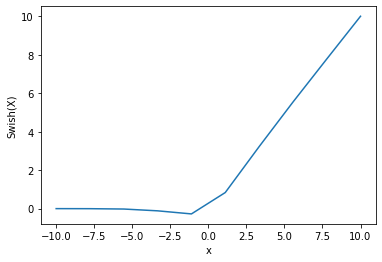

In [16]:
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Swish(X)")
plt.show();

### Model Architecture: Final Activation Layer

> [Sigmoid vs Softmax](https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier) I've noticed people often get directed to this question when searching whether to use sigmoid vs softmax in neural networks. If you are one of those people building a neural network classifier, here is how to decide whether to apply sigmoid or softmax to the raw output values from your network:

- If you have a multi-label classification problem = there is more than one "right answer" = the outputs are NOT mutually exclusive, then use a sigmoid function on each raw output independently. The sigmoid will allow you to have high probability for all of your classes, some of them, or none of them. Example: classifying diseases in a chest x-ray image. The image might contain pneumonia, emphysema, and/or cancer, or none of those findings.

---

- If you have a multi-class classification problem = there is only one "right answer" = the outputs are mutually exclusive, then use a softmax function. The softmax will enforce that the sum of the probabilities of your output classes are equal to one, so in order to increase the probability of a particular class, your model must correspondingly decrease the probability of at least one of the other classes. Example: classifying images from the MNIST data set of handwritten digits. A single picture of a digit has only one true identity - the picture cannot be a 7 and an 8 at the same time.

---

In the below code we understand that our model's `forward()` call gives us a output `output_logits` of shape (8, 11) if the batch size is 8, and the 11 represents each logit for each of the class. 

- If we apply `Softmax` to this function on `dimension=1`, it simply means we are applying the function each row, from row 1 to 8. Take row 1 for example, the softmax function will squash all the 11 values into a 0-1 range, you can say this is a probability calibration, and the `output_predictions` is also of shape `(8, 11)` but all sums up to 1.

- If we apply `Sigmoid` to this function on `dimension=1`, although PyTorch does not specifiy this because it automatically assumes we are applying sigmoid elementwise, that is to say you cannot simply pass an array of 11 elements to sigmoid function and but we are applying the sigmoid function each row as well. There is a lot of nuance and intricacies here. We take the first row as an example, the first element corresponds to the class **ETT-Abnormal**, when we apply `sigmoid` to this element 0.0762, we get 0.5190, and for the second element class **ETT-Borderline**, we have 0.0877 and when we apply sigmoid, we get 0.5219, so on and so forth for the first row. You should by now observe that they do not sum to 1. This is because each time sigmoid is applied, it is in a **one-vs-all** scenario. Meaning to say, the 0.519 for **ETT-Abnormal** means that **ETT-Abnormal** is treated as the positive class, and the remaining 10 classes are treated as negative class 0. In other words, with 11 elements and sigmoid, we are essentially performing 11 binary classification on the said 11 classes. So 0.519 actually means that the probability of it being class 1 (**ETT-Abnormal**) is 0.519, and the probability of it being NOT class 1 (ALL other classes) is 0.481. The same logic applies to each of the element in the first row. One thing worth noting is that the predictions for row 1 is not **mutually exclusive**, meaning that from the 11 classes, we can have say, **ETT-Abnormal, NGH-Abnormal, CVC-Abnormal** to all have say probability score of 0.9, meaning to say, it is highly likely to be all 3 conditions! This is okay and common in X-Ray imaging.

    - In the table dataframe below, I put them into a dataframe for easy visualization.




In [17]:
classes = [
    "ETT - Abnormal",
    "ETT - Borderline",
    "ETT - Normal",
    
    "NGT - Abnormal",
    "NGT - Borderline",
    "NGT - Incompletely Imaged",
    "NGT - Normal",
    
    "CVC - Abnormal",
    "CVC - Borderline",
    "CVC - Normal",
    
    "Swan Ganz Catheter Present",
]

In [22]:
import torch
import pandas as pd

output_logits = torch.tensor([  [ 0.0762,  0.0877,  0.1205, -0.0615, -0.0054,  0.0661,  0.1567, -0.0978, 0.0248, -0.0350,  0.0084],
                                [-0.0196, -0.0729,  0.0534,  0.0307, -0.0428, -0.0016,  0.0013, -0.0247, -0.0094, -0.0424,  0.0192],
                                [-0.0125, -0.0310,  0.0118, -0.1301,  0.0418,  0.0229,  0.0139, -0.0526, 0.0870, -0.0681, -0.0068],
                                [-0.0259, -0.0544, -0.0262,  0.0018,  0.0161, -0.0369, -0.0370, -0.0157, 0.0036, -0.0592,  0.0107],
                                [-0.0366, -0.0695,  0.0740, -0.0353, -0.0363, -0.0019,  0.0085, -0.0144, 0.0129, -0.0470,  0.0043],
                                [-0.0445, -0.0822,  0.0487, -0.0851,  0.0269, -0.0809, -0.0434,  0.0110, -0.0631, -0.0733, -0.0188],
                                [-0.0304,  0.0012,  0.0233, -0.0121, -0.0406, -0.0459, -0.0363,  0.0089,-0.0009, -0.0797, -0.0017],
                                [-0.0415,  0.0787,  0.0283, -0.0617, -0.0526, -0.0016, -0.0409, -0.0481, 0.0583, -0.0810, -0.0050]],
                                dtype=torch.float64, device = device)

In [23]:
sigmoid = torch.nn.Sigmoid()
softmax = torch.nn.Softmax(dim=1)
output_predictions_sigmoid = sigmoid(output_logits)
output_predictions_softmax = softmax(output_logits)
print(output_predictions_sigmoid)
print(output_predictions_softmax)

tensor([[0.5190, 0.5219, 0.5301, 0.4846, 0.4987, 0.5165, 0.5391, 0.4756, 0.5062,
         0.4913, 0.5021],
        [0.4951, 0.4818, 0.5133, 0.5077, 0.4893, 0.4996, 0.5003, 0.4938, 0.4977,
         0.4894, 0.5048],
        [0.4969, 0.4923, 0.5029, 0.4675, 0.5104, 0.5057, 0.5035, 0.4869, 0.5217,
         0.4830, 0.4983],
        [0.4935, 0.4864, 0.4935, 0.5004, 0.5040, 0.4908, 0.4908, 0.4961, 0.5009,
         0.4852, 0.5027],
        [0.4909, 0.4826, 0.5185, 0.4912, 0.4909, 0.4995, 0.5021, 0.4964, 0.5032,
         0.4883, 0.5011],
        [0.4889, 0.4795, 0.5122, 0.4787, 0.5067, 0.4798, 0.4892, 0.5027, 0.4842,
         0.4817, 0.4953],
        [0.4924, 0.5003, 0.5058, 0.4970, 0.4899, 0.4885, 0.4909, 0.5022, 0.4998,
         0.4801, 0.4996],
        [0.4896, 0.5197, 0.5071, 0.4846, 0.4869, 0.4996, 0.4898, 0.4880, 0.5146,
         0.4798, 0.4988]], dtype=torch.float64)
tensor([[0.0948, 0.0959, 0.0991, 0.0826, 0.0874, 0.0939, 0.1028, 0.0797, 0.0901,
         0.0849, 0.0886],
        [0.0900

In [24]:
df = pd.DataFrame(data =output_predictions_sigmoid.detach().cpu().numpy(), columns=classes)
display(df)

,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,0.519041,0.521911,0.530089,0.484630,0.498650,0.516519,0.539095,0.475569,0.506200,0.491251,0.502100
1,0.495100,0.481783,0.513347,0.507674,0.489302,0.499600,0.500325,0.493825,0.497650,0.489402,0.504800
2,0.496875,0.492251,0.502950,0.467521,0.510448,0.505725,0.503475,0.486853,0.521736,0.482982,0.498300
3,0.493525,0.486403,0.493450,0.500450,0.504025,0.490776,0.490751,0.496075,0.500900,0.485204,0.502675
4,0.490851,0.482632,0.518492,0.491176,0.490926,0.499525,0.502125,0.496400,0.503225,0.488252,0.501075
5,0.488877,0.479462,0.512173,0.478738,0.506725,0.479786,0.489152,0.502750,0.484230,0.481683,0.495300
6,0.492401,0.500300,0.505825,0.496975,0.489851,0.488527,0.490926,0.502225,0.499775,0.480086,0.499575
7,0.489626,0.519665,0.507075,0.484580,0.486853,0.499600,0.489776,0.487977,0.514571,0.479761,0.498750


### Batch Size and Tricks

Due to hardware limitation, we can barely fit in anything more than a `batch_size` of 8.

Quoting from [here](https://arxiv.org/abs/1609.04836):

> It has been observed in practice that when using a larger batch there is a degradation in the quality of the model, as measured by its ability to generalize [...]

> large-batch methods tend to converge to sharp minimizers of the training and testing functions—and as is well known, sharp minima lead to poorer generalization. In contrast, small-batch methods consistently converge to flat minimizers, and our experiments support a commonly held view that this is due to the inherent noise in the gradient estimation.

The above shows that large batch size may `fit` the model too well, as the model will learn features of the dataset in less iterations, and may memorize this particular dataset's features, leading to overfitting and poor generalization. However, too small a batch size causes our convergence to go too slow, empirically, we take 32 or 64 as the ideal batch size in this competition. 

We used both `torch.amp` and `gradient accumulation` to be able to fit more batch sizes. We did not freeze the `batch_norm` layers, which still yielded great results. What we should have done is to experiment more on how to freeze the batch norm layers properly, as I believe that it may help. In the end, we used a batch size of 8 and fit 4 iterations using `gradient accumulation`  and trained a total number of 20 epochs to get a local CV score of roughly 0.969.

### Optimizer, Scheduler and Loss

#### Scheduler

The configuration can be seen here. But note that we incorporated `GradualWarmUpScheduler` along with `CosineAnnealingLR`, we also experimented with `CosineAnnealingWarmRestarts`, the results are similar.

From the paper [Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour](https://arxiv.org/abs/1706.02677), we learnt about the warmup technique. Although the context of the paper was training under large batch size, we find it helpful even in small batches for the training to converge. 

The basic algorithm is as follows:

1. Set a base_lr or initial lr for what you want in a model, say 1e-4.
2. If we set our warmup epoch to be 10, then we will start from with 1e-4/10 in the first epoch, and take equal steps each time to converge to 1e-4 in the 10th epoch.
3. After the 10th epoch, warmup ends, we start applying our scheduler's normal steps.


However, I took quite some time to understand the idea of gradual warmup, I made my understanding [here](https://github.com/reigHns/reighns-pytorch-gradual-warmup-scheduler/blob/master/src/run.py).

We should try `OneCyclePolicy` as detailed by fastai.

```python
num_epochs = 20

CosineAnnealingLR:
    T_max: num_epochs - 1
    eta_min: 1.0e-07
    last_epoch: -1
    verbose: true
```

Notice in my configuration above, we set the parameter `T_max` to be the 19, which is like a one-shot training.

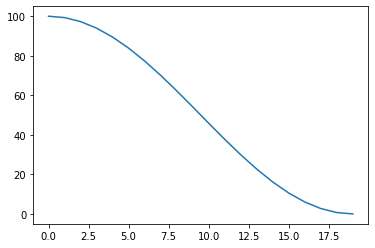

In [27]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20

model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=100)
cosine_annealing_lr_scheduler_one_shot = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=19, eta_min=1e-7)

cosine_annealing_lr_one_shot = []

for i in range(num_epochs):
    optimizer.step()
    cosine_annealing_lr_one_shot.append(optimizer.param_groups[0]["lr"])
    
#     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    cosine_annealing_lr_scheduler_one_shot.step()

plt.plot(cosine_annealing_lr_one_shot);

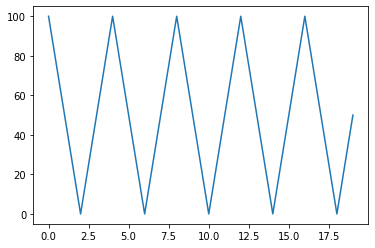

In [28]:
num_epochs = 20

model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=100)

cosine_annealing_lr_scheduler_normal= torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=1e-7)
cosine_annealing_lr_normal = []

for i in range(num_epochs):
    optimizer.step()
    cosine_annealing_lr_normal.append(optimizer.param_groups[0]["lr"])
    
#     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    cosine_annealing_lr_scheduler_normal.step()

plt.plot(cosine_annealing_lr_normal)

#### Loss

We should also experiment with `Focal Loss` but seeing negative results from fellow Kagglers, on top with limited resources, we did not try it.

## Ensembling

### Forward Ensembling

We made use of the [Forward Ensembling](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175614) idea from Chris in SIIM-ISIC Melanoma Classification back in August 2020, I modified the code for this specific task. A simple description is as follows, modified from Chris, with more mathematical notations.

1. We start off with a dataset $\mathcal{D} = X \times y$ where it is sampled from the true population $\mathcal{X} \times \mathcal{Y}$.
2. We apply KFold (5 splits) to the dataset, as illustrated in the diagram. 
3. We can now train five different hypothesis $h_{F1}, h_{F2},...,h_{F5}$, where $h_{F1}$ is trained on Fold 2 to Fold 5 and predict on Fold 1, $h_{F2}$ is trained on Fold 1,3,4,5 and predict on Fold 2. The logic follows for all 5 hypothesis.
4. Notice that in the five models, we are predicting on a unique validation fold, and as a result, after we trained all 5 folds, we will have the predictions made on the whole training set (F1-F5). This predictions is called the Out-of-Fold predictions.
5. We then go a step further and calculate the AUC score with the OOF predictions with the ground truth to get the OOF AUC. We save it to a csv or dataframe called **oof_1.csv**, subsequent oof trained on different hypothesis space should be named **oof_i.csv** where $i \in [2,3,...]$.
6. After we trained all 5 folds, we will use $h_{1}$ to predict on $X_{test}$ and obtain predictions $Y_{\text{h1 preds}}$, we then use $h_{2}$ to predict on $X_{test}$ and obtain predictions $Y_{\text{h2 preds}}$, we do this for all five folds and finally $Y_{\text{final preds}} = \dfrac{1}{5}\sum_{i=1}^{5}Y_{\text{hi preds}}$. This is a typical pipeline in most machine learning problems. We save this final predictions as **sub_1.csv**, subsequence predictions trained on different hypothesis space should be named **sub_i.csv** where $i \in [2,3,...]$.
7. Now if we train another model, a completely different hypothesis space is used, to be more pedantic, we denote the previous model to be taken from the hypothesis space $\mathcal{H}_{1}$, and now we move on to $\mathcal{H}_{2}$. We repeat step 1-6 on this new model (Note that you are essentially training 10 "models" now since we are doing KFold twice, and oh, please set the seed of KFold to be the same, it should never be the case that both model comes from different splitting seed for apparent reasons).

---

Here is the key (given the above setup with 2 different models trained on 5 folds):

1. Normally, most people do a simple mean ensemble, that is $\dfrac{Y_{\text{final preds H1}} + Y_{\text{final preds H2}}}{2}$. This works well most of the time as we trust both model holds equal importance in the final predictions.
2. One issue may be that certain models should be weighted more than the rest, we should not simply take Leaderboard feedback score to judge the weight assignment. A general heuristic here is called Forward Selection.
3. (Extract from Chris) Now say that you build 2 models (that means that you did 5 KFold twice). You now have oof_1.csv, oof_2.csv, sub_1.csv, and sub_2.csv. How do we blend the two models? We find the weight w such that `w * oof_1.predictions + (1-w) * oof_2.predictions` has the largest AUC.

```python
all = []
for w in [0.00, 0.01, 0.02, ..., 0.98, 0.99, 1.00]:
    ensemble_pred = w * oof_1.predictions + (1-w) * oof_2.predictions
    ensemble_auc = roc_auc_score( oof.target , ensemble_pred )
    all.append( ensemble_auc )
best_weight = np.argmax( all ) / 100.
```

Then we can assign the best weight like:

```python
final_ensemble_pred = best_weight * sub_1.target + (1-best_weight) * sub_2.target
```

<img src='https://drive.google.com/uc?id=12Mpa_9pTdNYizDCVxq_VxX5qx5j84Y1X' width="500"/>
Coutersy of Chris

---

In this competition, there are two approaches, either maximize the average of the macro AUC score of all the classes, or maximize each column/class separately. It turns out that maximizing the columns separately led to disastrous results (it could be my code and idea is wrong, as ROC is a ranking metric). 

## Conclusion

What we could have done better:

- Use more variety of `classifier head` like `GeM`.
- Use more variety of `backbone`.
- Use [Neptune.ai](http://neptune.ai) to log our experiments as soon things start to get messy. Basically MLOps is important!
- Experiment on 3-4 stage training.
- Pseudo Labelling.
- Knowledge Distillation.
- Experiment more on maximizing AUC during ensembles. `rank_pct` etc.

- **See novel three stage training: https://www.kaggle.com/yasufuminakama/ranzcr-resnet200d-3-stage-training-step1**

## References

- [Multi-Head Deep Learning Model with Multi-Label Classification](https://debuggercafe.com/multi-head-deep-learning-models-for-multi-label-classification/)

- [AUC Metric on Multi-Label](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

- [Sigmoid and Softmax for Multi-Label](https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)

- [Multi-Label Classification Tutorial](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

- [Why we should use Multi-Head in Multi-Label Classification](https://debuggercafe.com/multi-head-deep-learning-models-for-multi-label-classification/)
    - [Follow Up 1](https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/)
    - [Follow Up 2](https://debuggercafe.com/multi-label-fashion-item-classification-using-deep-learning-and-pytorch/)
    - [Follow Up 3](https://debuggercafe.com/deep-learning-architectures-for-multi-label-classification-using-pytorch/)

- [Sigmoid is Binary Cross Entropy](https://stats.stackexchange.com/questions/485551/1-neuron-bce-loss-vs-2-neurons-ce-loss)

- [Attention Blocks in Computer Vision](https://towardsdatascience.com/attention-in-computer-vision-fd289a5bd7ad)

- [Spatial Attention Blocks](https://medium.com/visionwizard/understanding-attention-modules-cbam-and-bam-a-quick-read-ca8678d1c671)

- [Spatial Attention Module](https://paperswithcode.com/method/spatial-attention-module)

- [Convolutional Block Attention Module](https://arxiv.org/abs/1807.06521)

- [Dive Into Deep Learning - Chapter 10: Attention Mechanisms]

- [Gradual Warmup: Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour](https://arxiv.org/abs/1706.02677)